**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd, adam
from keras.layers import Flatten, Conv2D, MaxPooling2D, Activation, AveragePooling2D, Reshape, BatchNormalization, Dropout

Using TensorFlow backend.


# MiniProject on Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi) = \sum_{t \leq T} E_{p^\pi} \left[ \gamma^t r(s_t, a_t) \right] \> ,
\end{equation*}

where: 
\begin{equation*}
p^\pi \left( a_0, a_1, s_1, \dots, a_T, s_T \right) = p(a_0) \prod_{t=1}^T \pi(a_t| s_t) p(s_{t+1} | s_t, a_t) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}
Q^\pi (s, a) = E_{p^\pi} \left[ \sum_{t \leq T} \gamma^t r(s_t, a_t) \,\middle\vert\, s_0 = s, a_0 = a \right] \> .
\end{equation*}

Thus, the optimal $Q$-function is:
\begin{equation*}
Q^* (s, a) = \max_\pi Q^\pi (s, a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [2]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [3]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        """
        The agent acts (uniformly) at random with probability epsilon and can choose 
        n_action different actions.
        """
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self, e):
        """
        Change the random exploration parameter epsilon.
        """
        self.epsilon = e

    def act(self, s, train=True):
        """
        This function should return the next action to do:
        an integer between 0 and n_action (not included) with a random exploration of epsilon.
        
        :return: an action a
        """
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """
        Act via the policy of the agent, from a given state s
        it proposes an action a.
        """
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """
        This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """
        This function returns basic stats if applicable: the
        loss and/or the model
        """
        pass

    def load(self):
        """
        This function allows to restore a model
        """
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

__Solution 1__: ```epsilon``` is essential for exploration during the training. Indeed, with probability ```epsilon```, the agent chooses an action at random and follows the policy otherwise. Thus, the agent can try new possibilities during the training and obtain better rewards.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [4]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size + 4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        # board on which one plays
        self.board = np.zeros((grid_size, grid_size))
        self.position = np.zeros((grid_size, grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale = 16

        self.to_draw = np.zeros((max_time + 2, grid_size * self.scale, grid_size * self.scale, 3))

    def draw(self, e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self, t):
        b = np.zeros((self.grid_size, self.grid_size, 3)) + 128
        b[self.board > 0, 0] = 256
        b[self.board < 0, 2] = 256
        b[self.x, self.y, :] = 256
        b[-2:, :, :] = 0
        b[:, -2:, :] = 0
        b[:2, :, :] = 0
        b[:, :2, :] = 0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t, :, :, :] = b

    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2, :] = -1
        self.position[:, 0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size - 3:
                self.x = self.x - 1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x + 1
            else:
                self.x = self.x - 1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate(
            (self.board.reshape(self.grid_size, self.grid_size, 1), 
             self.position.reshape(self.grid_size, self.grid_size, 1)
            ), axis=2)
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size - 3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size - 3, size=1)[0]


        bonus = 0.5 * np.random.binomial(1, self.temperature, size=self.grid_size ** 2)
        bonus = bonus.reshape(self.grid_size, self.grid_size)

        malus = -1.0 * np.random.binomial(1, self.temperature, size=self.grid_size ** 2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time + 2, self.grid_size * self.scale, self.grid_size * self.scale, 3))


        malus[bonus > 0] = 0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2, :] = -1
        self.position[:, 0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        self.board[self.x, self.y] = 0
        self.t = 0

        state = np.concatenate(
            (self.board.reshape(self.grid_size, self.grid_size, 1),
             self.position.reshape(self.grid_size, self.grid_size, 1)
            ), axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [5]:
# parameters
size = 13
T = 200
temperature = 0.3
epochs_train = 10 # set small when debugging
epochs_test = 10 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

__Solution 2__: The array ```position``` indicates the position of the agent. ```position[i, j]``` is $1$ if the agent is at the position $(i, j)$.

The array ```board``` indicates the elements present on the board. ```board[i, j]``` indicates if there is cheese, poison, or nothing at the position $(i, j)$.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [6]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        """
        Choose randomly an action.
        
        :return: an action
        """
        
        return np.random.randint(self.n_action)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [7]:
def test(agent, env, epochs, prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        
        ##### FILL IN HERE
        state = env.reset()
        game_over = False
        win, lose = 0, 0
        
        while not game_over:
            previous_state = state
            
            # given a state, the agent chooses an action...
            action = agent.act(previous_state)
            
            # ... and the environment returns a new state and a reward
            state, reward, game_over = env.act(action)
            
            if reward > 0:
                win += reward
            else:
                lose -= reward
        
        # Save as a mp4
        env.draw(prefix + str(e))

        # Update stats
        score = score + win - lose

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score / (1 + e)))
    print('Final score: ' + str(score / epochs))

In [8]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random0.mp4'))

Win/lose count 15.5/13.0. Average score (2.5)
Win/lose count 11.5/10.0. Average score (2.0)
Win/lose count 9.0/13.0. Average score (0.0)
Win/lose count 10.0/19.0. Average score (-2.25)
Win/lose count 9.5/23.0. Average score (-4.5)
Win/lose count 5.0/10.0. Average score (-4.583333333333333)
Win/lose count 11.0/12.0. Average score (-4.071428571428571)
Win/lose count 15.0/15.0. Average score (-3.5625)
Win/lose count 11.5/12.0. Average score (-3.2222222222222223)
Win/lose count 14.5/17.0. Average score (-3.15)
Final score: -3.15


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^\pi(s, a) = E_{(s', a') \sim p^\pi(\cdot | s, a)} \left[ r(s, a) + \gamma Q^\pi(s', a') \right]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^* (s, a) = E_{s' \sim \pi^* (\cdot| s, a)} \left[ r(s, a) + \gamma \max_{a'} Q^*(s', a') \right]
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L} \left( \theta \right) = E_{s' \sim \pi^* (\cdot | s, a)} \left( \left|\left| r + \gamma \max_{a'} Q(s', a', \theta) - Q(s, a, \theta) \right|\right|^{2} \right)
\end{equation*}

__Solution 5__:

We have:
\begin{equation*}
\begin{aligned}
Q^\pi(s,a) &= E_{p^{\pi}} \left[ \sum_{0 \leq t \leq T} \gamma^t r(s_t, a_t) \,\middle\vert\, s_0 = s, a_0 = a \right] & \text{(definition)} \\
&= E_{p^{\pi}} \left[ r(s_0, a_0) + \sum_{1 \leq t \leq T} \gamma^t r(s_t, a_t) \,\middle\vert\, s_0 = s, a_0 = a \right] \\
&= r(s, a) + \gamma E_{p^{\pi}} \left[ \sum_{1 \leq t \leq T} \gamma^{t-1} r(s_t, a_t) \,\middle\vert\, s_0 = s, a_0 = a \right] \\
&= r(s, a) + \gamma E_{p^\pi(a_1, s_1, \dots, a_T, s_T | s_0 = s, a_0 = a)} \left[ \sum_{1 \leq t \leq T} \gamma^{t-1} r(s_t, a_t) \right] \\
&= r(s, a) + \gamma E_{p^{\pi}(a_1, s_1 | s_0 = s, a_0 = a)} \left( E_{p^{\pi}(a_2, s_2, \dots, a_T, s_T | a_1, s_1)} \left[ \sum_{1 \leq t \leq T} \gamma^{t-1} r(s_t, a_t) \right] \right) & \text{(Markov property)} \\
&= r(s, a) + \gamma E_{p^{\pi}(a_1, s_1 | s_0 = s, a_0 = a)} \left[ Q^\pi(s_1, a_1) \right] \\
&= E_{p^{\pi}(a_1, s_1 | s_0 = s, a_0 = a)} \left[ r(s, a) + \gamma Q^\pi(s_1, a_1) \right]
\end{aligned}
\end{equation*}

Hence,
\begin{equation*}
\boxed{Q^\pi(s, a) = E_{(s', a') \sim p^\pi(\cdot | s, a)} \left[ r(s, a) + \gamma Q^\pi(s', a') \right]}
\end{equation*}

For the optimal Q-function, we have:
\begin{equation*}
\begin{aligned}
Q^* (s, a) &= \max_\pi Q^\pi(s, a) \\
&= r(s, a) + \max_\pi E_{(s', a') \sim p^\pi (\cdot | s, a)} \left[ \gamma Q^\pi(s', a') \right] \\
&= r(s, a) + \gamma E_{(s', a') \sim p^{\pi^*} (\cdot | s, a)} \left[ Q^{\pi^*} (s', a') \right]
\end{aligned}
\end{equation*}

The optimal policy is given, for a state $s$, by $\pi^* (s) = \arg\max_a Q^* (s, a)$. Hence,

\begin{equation*}
Q^* (s, a) = r(s, a) + \gamma E_{s' \sim \pi^* (\cdot | s, a)} \left[ \max_{a'} Q^* (s, a') \right]
\end{equation*}

and

\begin{equation*}
\boxed{Q^* (s, a) = E_{s' \sim \pi^* (\cdot| s, a)} \left[ r(s, a) + \gamma \max_{a'} Q^*(s', a') \right]}
\end{equation*}

The goal is to find a policy $\pi$, or equivalently a Q-function $Q^\pi$, such that the optimal Bellman equation is satisfied (or in practice, almost satisfied):

\begin{equation*}
Q^\pi(s,a) = E_{s' \sim p(.|s,a)}[r(s,a) + \gamma \max_{a'} Q^\pi(s',a')]
\end{equation*}

This means that in expectation (w.r.t. $s'$), we want $Q^\pi (s, a) - r(s, a) + \gamma \max_{a'} Q^\pi (s', a')$ to be close to $0$. Hence, it is natural to consider the loss $\mathcal{L}$ given by:
\begin{equation*}
\boxed{\mathcal{L} \left( \theta \right) = E_{s' \sim \pi^* (\cdot | s, a)} \left( \left|\left| r + \gamma \max_{a'} Q(s', a', \theta) - Q(s, a, \theta) \right|\right|^{2} \right)}
\end{equation*}

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [9]:
import random

class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        """
        Remember the move m. If the memory is full, forget the oldest move and add the most recent one.
        """
        if len(self.memory) > self.max_memory:
            del self.memory[0]
        
        self.memory.append(m)

    def random_access(self):
        """
        Choose randomly an element from the list of saved moves.
        """
        return random.choice(self.memory)

***
The pipeline we will use for training is given below:

In [10]:
def train(agent, env, epoch, prefix=''):
    # Number of won games
    score = 0
    loss = 0
    
    scores = []
    losses = []

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0
        average_loss = 0
        
        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)
            average_loss += loss
            
        losses.append(average_loss / env.max_time)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix + str(e))

        # Update stats
        score += win - lose
        scores.append(win - lose)

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win - lose))
        agent.save(name_weights=prefix + 'model.h5', name_model=prefix + 'model.json')
        
    return losses, scores

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [66]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon=0.1, memory_size=100, batch_size=16, n_state=2):
        super(DQN, self).__init__(epsilon=epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        return np.argmax(self.model.predict(np.array([s])))

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5, 5, self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            ######## FILL IN
            s_, n_s_, a_, r_, game_over_ = self.memory.random_access()
            target_q[i] = self.model.predict(np.array([n_s_]))
            
            if game_over_:
                ######## FILL IN
                target_q[i, a_] = r_
            else:
                ######## FILL IN
                target_q[i, a_] = r_ + self.discount * np.max(target_q[i])
            
            ######## FILL IN
            input_states[i] = s_
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)

        l = self.model.train_on_batch(input_states, target_q)

        return l

    def save(self, name_weights='model.h5', name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self, name_weights='model.h5', name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1, **kwargs):
        super(DQN_FC, self).__init__(*args, **kwargs)
        
        # NN Model
        ####### FILL IN
        hidden_size = 64
        
        model = Sequential([
            Flatten(),
            Dense(hidden_size),
            Activation('relu'),
            Dense(self.n_action)
        ])
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), 'mse')
        # model.compile(adam(lr=lr), 'mse')
        self.model = model

In [67]:
epochs_train = 101

env = Environment(grid_size=size, max_time=T, temperature=.3)
agent = DQN_FC(size, lr=1e-1, epsilon=.1, memory_size=2000, batch_size=32)

losses, scores = train(agent, env, epochs_train, prefix='fc_train')
HTML(display_videos('fc_train{}.mp4'.format(epochs_train-1)))

Epoch 000/101 | Loss 0.0118 | Win/lose count 6.0/3.0 (3.0)
Epoch 001/101 | Loss 0.0216 | Win/lose count 5.5/6.0 (-0.5)
Epoch 002/101 | Loss 0.0727 | Win/lose count 3.0/2.0 (1.0)
Epoch 003/101 | Loss 0.0153 | Win/lose count 6.5/5.0 (1.5)
Epoch 004/101 | Loss 0.0230 | Win/lose count 6.0/6.0 (0.0)
Epoch 005/101 | Loss 0.0156 | Win/lose count 3.5/6.0 (-2.5)
Epoch 006/101 | Loss 0.0254 | Win/lose count 3.5/2.0 (1.5)
Epoch 007/101 | Loss 0.0095 | Win/lose count 3.5/7.0 (-3.5)
Epoch 008/101 | Loss 0.0099 | Win/lose count 1.0/4.0 (-3.0)
Epoch 009/101 | Loss 0.0071 | Win/lose count 6.5/1.0 (5.5)
Epoch 010/101 | Loss 0.0109 | Win/lose count 9.5/3.0 (6.5)
Epoch 011/101 | Loss 0.0044 | Win/lose count 3.5/8.0 (-4.5)
Epoch 012/101 | Loss 0.0061 | Win/lose count 8.0/5.0 (3.0)
Epoch 013/101 | Loss 0.0135 | Win/lose count 5.5/5.0 (0.5)
Epoch 014/101 | Loss 0.0146 | Win/lose count 8.0/7.0 (1.0)
Epoch 015/101 | Loss 0.0163 | Win/lose count 4.0/3.0 (1.0)
Epoch 016/101 | Loss 0.0072 | Win/lose count 4.0/1.

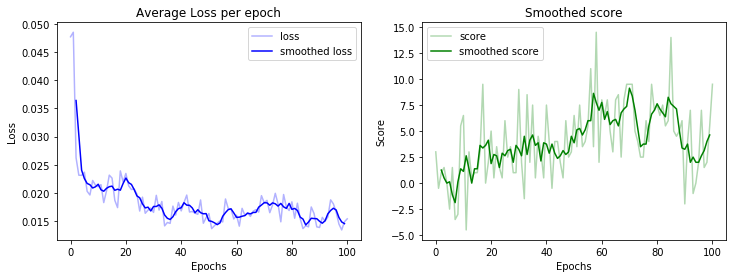

In [68]:
def plot_performances(losses, scores, window_size=4):
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.title('Average Loss per epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses, alpha=.3, c='b', label='loss')
    plt.plot(np.arange(window_size//2, epochs_train - window_size//2 + 1),
             np.convolve(losses, np.ones((window_size,)) / window_size, mode='valid'),
             c='b', label='smoothed loss')
    plt.legend(loc='best')

    plt.subplot(122)
    plt.title('Smoothed score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.plot(scores, alpha=.3, c='g', label='score')
    plt.plot(np.arange(window_size//2, epochs_train - window_size//2 + 1), 
             np.convolve(scores, np.ones((window_size,)) / window_size , mode='valid'),
             c='g', label='smoothed score')
    plt.legend(loc='best')

    plt.show()

plot_performances(losses, scores)

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [69]:
class DQN_CNN(DQN):
    def __init__(self, *args, lr=0.1, **kwargs):
        super(DQN_CNN, self).__init__(*args, **kwargs)
        
        ###### FILL IN
        model = Sequential([
            Conv2D(16, 3, padding='same'),
            Activation('relu'),
            Conv2D(32, 3, padding='same'),
            Activation('relu'),
            Flatten(),
            Dense(64),
            Activation('relu'),
            Dense(self.n_action)
        ])
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), 'mse')
        # model.compile(adam(lr=lr), 'mse')
        self.model = model

In [70]:
epochs_train = 101

env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=1e-1, epsilon=0.1, memory_size=2000, batch_size=32)
losses, scores = train(agent, env, epochs_train, prefix='cnn_train')
HTML(display_videos('cnn_train{}.mp4'.format(epochs_train-1)))

Epoch 000/101 | Loss 0.0091 | Win/lose count 4.5/5.0 (-0.5)
Epoch 001/101 | Loss 0.0607 | Win/lose count 13.5/11.0 (2.5)
Epoch 002/101 | Loss 0.0086 | Win/lose count 17.5/5.0 (12.5)
Epoch 003/101 | Loss 0.0041 | Win/lose count 5.0/3.0 (2.0)
Epoch 004/101 | Loss 0.0188 | Win/lose count 11.0/7.0 (4.0)
Epoch 005/101 | Loss 0.0468 | Win/lose count 6.5/2.0 (4.5)
Epoch 006/101 | Loss 0.0038 | Win/lose count 10.0/6.0 (4.0)
Epoch 007/101 | Loss 0.0136 | Win/lose count 7.0/4.0 (3.0)
Epoch 008/101 | Loss 0.0105 | Win/lose count 9.5/3.0 (6.5)
Epoch 009/101 | Loss 0.0085 | Win/lose count 15.0/3.0 (12.0)
Epoch 010/101 | Loss 0.0043 | Win/lose count 12.0/4.0 (8.0)
Epoch 011/101 | Loss 0.0088 | Win/lose count 4.0/5.0 (-1.0)
Epoch 012/101 | Loss 0.0045 | Win/lose count 9.0/4.0 (5.0)
Epoch 013/101 | Loss 0.0311 | Win/lose count 3.5/0 (3.5)
Epoch 014/101 | Loss 0.0041 | Win/lose count 12.0/3.0 (9.0)
Epoch 015/101 | Loss 0.0605 | Win/lose count 10.5/3.0 (7.5)
Epoch 016/101 | Loss 0.0051 | Win/lose count 

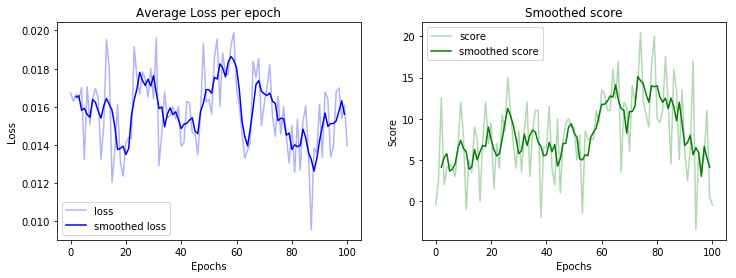

In [71]:
plot_performances(losses, scores)

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [72]:
epochs_test = 11

env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon=0.1, memory_size=2000, batch_size=32)
agent_cnn.load(name_weights='cnn_trainmodel.h5', name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon=0.1, memory_size=2000, batch_size=32)
agent_fc.load(name_weights='fc_trainmodel.h5', name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn, env, epochs_test, prefix='cnn_test')
print('Test of the FC')
test(agent_fc, env, epochs_test, prefix='fc_test')

Test of the CNN
Win/lose count 3.0/5.0. Average score (-2.0)
Win/lose count 5.0/6.0. Average score (-1.5)
Win/lose count 5.0/1.0. Average score (0.3333333333333333)
Win/lose count 5.0/3.0. Average score (0.75)
Win/lose count 7.5/3.0. Average score (1.5)
Win/lose count 5.5/5.0. Average score (1.3333333333333333)
Win/lose count 8.0/2.0. Average score (2.0)
Win/lose count 5.5/3.0. Average score (2.0625)
Win/lose count 3.5/1.0. Average score (2.111111111111111)
Win/lose count 5.0/0.0. Average score (2.4)
Win/lose count 9.0/1.0. Average score (2.909090909090909)
Final score: 2.909090909090909
Test of the FC
Win/lose count 4.5/3.0. Average score (1.5)
Win/lose count 2.5/1.0. Average score (1.5)
Win/lose count 4.0/3.0. Average score (1.3333333333333333)
Win/lose count 6.5/3.0. Average score (1.875)
Win/lose count 4.5/2.0. Average score (2.0)
Win/lose count 8.0/6.0. Average score (2.0)
Win/lose count 4.5/2.0. Average score (2.0714285714285716)
Win/lose count 2.0/0.0. Average score (2.0625)
Win

In [73]:
HTML(display_videos('cnn_test10.mp4'))

In [74]:
HTML(display_videos('fc_test10.mp4'))

__Solution 9__: When we increase the temperature, we increase both the probabilities of having a cheese or a poison on a given cell. However, as we first put the cheese and then the poison, increasing the temperature increases the number of cheese and reduces the number of poison on the board. Naturally, this yields better rewards but it does not mean the agent is better.

Indeed, we notice that **there is an issue regarding the exploration**. When the temperature is low, there are a lot of empty cells and the agent is easily stuck in an empty part of the board. This seems to be a strategy to avoid the poison but at the same time, the agent also avoids the cheese. When the temperature is higher, the agent first cleans a part of the board and then is likely to get stuck in this now-empty part of the board. In other words, the agent gets easily stuck into a local minima.

Besides, we notice that the CNN yields better performance than the MLP.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [84]:
def train_explore(agent, env, epoch, prefix=''):
    # Number of won games
    score = 0
    loss = 0
    
    # Decreasing epsilon factor
    gamma = .95
    
    # To record the performances during the training
    scores = []
    losses = []

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0
        average_loss = 0
        
        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action, train=True)

            # Update the counters
            # to avoid having very low scores because of the malus position, we only
            # count the reward if the agent ate a cheese or a poison
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)
            average_loss += loss
            
        losses.append(average_loss / env.max_time)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix + str(e))

        # Update stats
        score += win - lose
        scores.append(win - lose)

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {:.4f}/{:.4f} ({:.4f}) | Epsilon {:.4f}"
              .format(e, epoch, loss, win, lose, win - lose, agent.epsilon))
        agent.save(name_weights=prefix + 'model.h5', name_model=prefix + 'model.json')
        
        # decreasing epsilon-greedy exploration
        agent.set_epsilon(max(0.1, gamma * agent.epsilon))
        
    return losses, scores


class EnvironmentExploring(Environment):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        
        # keep the previous environment
        super(EnvironmentExploring, self).__init__(grid_size=grid_size, 
                                                   max_time=max_time, 
                                                   temperature=temperature)
        
        # new feature to encourage exploration
        self.malus_position = np.zeros((self.grid_size, self.grid_size))
    
    def act(self, action, train=True):
        
        # act as before
        _, reward, game_over = super(EnvironmentExploring, self).act(action)
        
        if train:
            # if the position has already been visited, apply a malus
            reward -= self.malus_position[self.x, self.y]
            
        # set up the malus after a cell has been visited
        self.malus_position[self.x, self.y] = 0.1

        # concatenate features
        state = np.concatenate((
            self.malus_position.reshape(self.grid_size, self.grid_size, 1), 
            self.board.reshape(self.grid_size, self.grid_size, 1), 
            self.position.reshape(self.grid_size, self.grid_size, 1)
        ), axis=2)
        
        # keep 5x5 window around the agent
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        
        return state, reward, game_over

    def reset(self):
        
        # reset everything as before
        super(EnvironmentExploring, self).reset()
        
        # reset the malus_position grid
        self.malus_position = np.zeros((self.grid_size, self.grid_size))

        # concatenate features
        state = np.concatenate((
            self.malus_position.reshape(self.grid_size, self.grid_size, 1), 
            self.board.reshape(self.grid_size, self.grid_size, 1), 
            self.position.reshape(self.grid_size, self.grid_size, 1)
        ), axis=2)
        
        # keep 5x5 window around the agent
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        
        return state

In [89]:
# Training
epochs_train = 101
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=5e-2, epsilon=1, memory_size=2000, batch_size=32, n_state=3)
losses, scores = train_explore(agent, env, epochs_train, prefix='cnn_train_explore')
HTML(display_videos('cnn_train_explore10.mp4'))

Epoch 000/101 | Loss 0.0185 | Win/lose count 5.5000/30.9000 (-25.4000) | Epsilon 1.0000
Epoch 001/101 | Loss 0.0137 | Win/lose count 11.0000/31.8000 (-20.8000) | Epsilon 0.9500
Epoch 002/101 | Loss 0.0157 | Win/lose count 11.0000/29.2000 (-18.2000) | Epsilon 0.9025
Epoch 003/101 | Loss 0.0262 | Win/lose count 10.5000/30.4000 (-19.9000) | Epsilon 0.8574
Epoch 004/101 | Loss 0.0148 | Win/lose count 6.5000/28.3000 (-21.8000) | Epsilon 0.8145
Epoch 005/101 | Loss 0.0191 | Win/lose count 3.0000/20.5000 (-17.5000) | Epsilon 0.7738
Epoch 006/101 | Loss 0.0249 | Win/lose count 11.0000/33.4000 (-22.4000) | Epsilon 0.7351
Epoch 007/101 | Loss 0.0351 | Win/lose count 14.0000/21.7000 (-7.7000) | Epsilon 0.6983
Epoch 008/101 | Loss 0.0159 | Win/lose count 15.5000/21.7000 (-6.2000) | Epsilon 0.6634
Epoch 009/101 | Loss 0.0262 | Win/lose count 4.5000/24.8000 (-20.3000) | Epsilon 0.6302
Epoch 010/101 | Loss 0.0206 | Win/lose count 14.0000/24.1000 (-10.1000) | Epsilon 0.5987
Epoch 011/101 | Loss 0.0131

Epoch 094/101 | Loss 0.0247 | Win/lose count 23.5000/15.9000 (7.6000) | Epsilon 0.1000
Epoch 095/101 | Loss 0.0182 | Win/lose count 15.5000/15.4000 (0.1000) | Epsilon 0.1000
Epoch 096/101 | Loss 0.0210 | Win/lose count 19.5000/20.4000 (-0.9000) | Epsilon 0.1000
Epoch 097/101 | Loss 0.0273 | Win/lose count 27.0000/18.9000 (8.1000) | Epsilon 0.1000
Epoch 098/101 | Loss 0.0592 | Win/lose count 21.5000/15.4000 (6.1000) | Epsilon 0.1000
Epoch 099/101 | Loss 0.0263 | Win/lose count 15.5000/17.1000 (-1.6000) | Epsilon 0.1000
Epoch 100/101 | Loss 0.0264 | Win/lose count 17.5000/17.2000 (0.3000) | Epsilon 0.1000


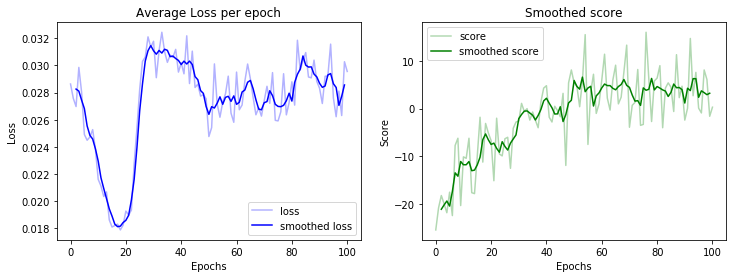

In [90]:
plot_performances(losses, scores)

In [91]:
# Evaluation
test(agent, env, epochs_test, prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4'))

Win/lose count 23.0/22.300000000000026. Average score (0.6999999999999744)
Win/lose count 13.5/16.699999999999978. Average score (-1.2500000000000018)
Win/lose count 24.5/13.69999999999998. Average score (2.7666666666666724)
Win/lose count 21.5/15.099999999999973. Average score (3.6750000000000114)
Win/lose count 20.5/15.399999999999979. Average score (3.9600000000000137)
Win/lose count 21.0/13.399999999999977. Average score (4.5666666666666815)
Win/lose count 24.5/16.799999999999983. Average score (5.014285714285729)
Win/lose count 26.5/13.299999999999981. Average score (6.037500000000016)
Win/lose count 26.0/12.299999999999972. Average score (6.888888888888906)
Win/lose count 20.0/13.199999999999973. Average score (6.8800000000000185)
Win/lose count 26.0/13.19999999999998. Average score (7.418181818181837)
Final score: 7.418181818181837


__Solution 10__: We can see that the agent is not stuck anymore and explore the board to retrieve the cheese. It results in better performances.

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***